# **Данные**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from scipy.stats import norm, multivariate_normal, gaussian_kde, dirichlet, wishart
from scipy.integrate import quad, nquad
from scipy.special import gammaln, psi, digamma, gamma
from scipy.linalg import det, inv

In [4]:
# data = pd.read_excel('euro_dollar_without_crisis.xlsx')
data = pd.read_excel('euro_dollar.xlsx')
data = data.sort_values(by = ['curs_euro'])
data.head()

,date,curs_dollar,curs_euro,cum_dollar,cum_euro
3809,2014-12-18,-0.128638,-0.142679,1.232742,1.556321
5605,2022-04-07,-0.079885,-0.084087,1.482782,1.517790
3811,2014-12-20,-0.071521,-0.074047,1.110268,1.406443
5595,2022-03-24,-0.071473,-0.071291,2.151096,2.210241
5638,2022-05-28,-0.051060,-0.070371,1.020191,0.915850


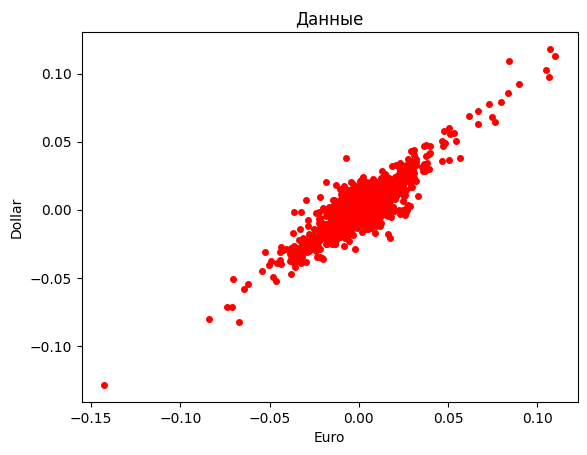

In [5]:
list_of_euro = list(data['curs_euro'])
list_of_dollar = list(data['curs_dollar'])
n_samples = data['curs_euro'].size
n_samples
plt.title('Данные')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
#plt.legend(['С шумом', 'Истинный'])
plt.show()

In [6]:
np_data_dollar = np.array(data['curs_dollar']).reshape(-1, 1)
np_data_euro = np.array(data['curs_euro']).reshape(-1, 1)
np_data_euro

array([[-0.14267898],
       [-0.08408749],
       [-0.07404701],
       ...,
       [ 0.10664213],
       [ 0.10718334],
       [ 0.10994489]])

In [7]:
data_XY = np.concatenate([np_data_euro, np_data_dollar], axis = 1)
data_XY

array([[-0.14267898, -0.12863818],
       [-0.08408749, -0.07988462],
       [-0.07404701, -0.07152092],
       ...,
       [ 0.10664213,  0.09724502],
       [ 0.10718334,  0.11812002],
       [ 0.10994489,  0.11316388]])

# **Расчёт метода в двумерном случае**

## **Разделяем на смесь**

### **Выбор модели по BIC**

In [7]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 20),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(data_XY)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 20)},
             scoring=<function gmm_bic_score at 0x000002E43B5FB380>)

In [8]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
58,2,full,-15906.949549
19,1,tied,-15521.164018
57,1,full,-15521.164018
59,3,full,-15089.135346
1,2,spherical,-14880.545651


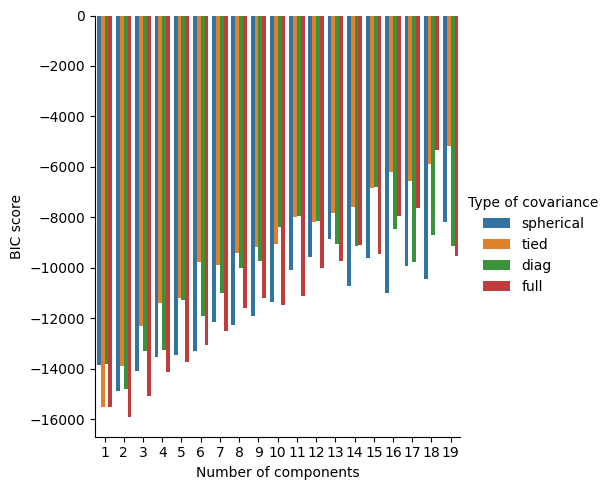

In [9]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

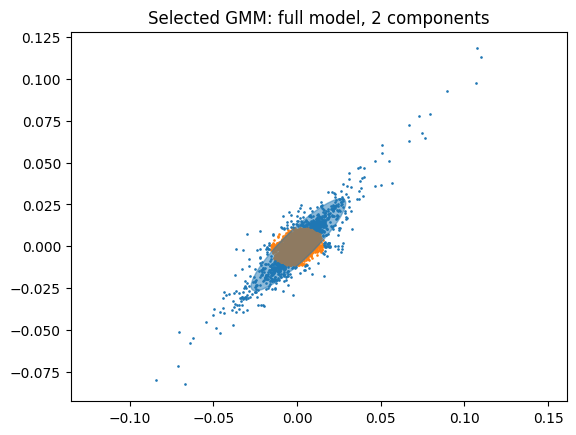

In [10]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(data_XY)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(data_XY[Y_ == i, 0], data_XY[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()

In [11]:
best_2_dim_gmm = grid_search.best_estimator_
best_2_dim_gmm.weights_

array([0.84438596, 0.15561404])

### **Строим регрессию на примере**

In [12]:
best_2_dim_gmm = mixture.GaussianMixture(n_components=12)
best_2_dim_gmm.fit(data_XY)
best_2_dim_gmm.covariances_.shape

(12, 2, 2)

In [13]:
def cur_pdf_2_dim_dot_y (y, a):
    p_a_y = 0
    for i in range(best_2_dim_gmm.means_.shape[0]):
        p_a_y += multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i]

    return p_a_y * y

def cur_pdf_2_dim (y, a):
    p_a_y = 0
    for i in range(best_2_dim_gmm.means_.shape[0]):
        p_a_y += multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i]

    return p_a_y

In [14]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
for a in a_s:
    # if p_a != 0:
    print(a)
    res.append(quad(cur_pdf_2_dim_dot_y, -np.inf, np.inf, args=(a))[0]/ quad(cur_pdf_2_dim, -np.inf, np.inf, args=(a))[0])
    # else:
    #     res.append(0)

-0.1
-0.099
-0.098
-0.097
-0.096
-0.095
-0.094
-0.093
-0.092
-0.091
-0.09
-0.089
-0.088
-0.087
-0.086
-0.085
-0.084
-0.083
-0.082
-0.081
-0.08
-0.079
-0.078
-0.077
-0.076
-0.075
-0.074
-0.073
-0.072
-0.071
-0.07
-0.069
-0.068
-0.067
-0.066
-0.065
-0.064
-0.063
-0.062
-0.061
-0.06
-0.059
-0.058
-0.057
-0.056
-0.055
-0.054
-0.053
-0.052
-0.051
-0.05
-0.049
-0.048
-0.047
-0.046
-0.045
-0.044
-0.043
-0.042
-0.041
-0.04
-0.039
-0.038
-0.037
-0.036
-0.035
-0.034
-0.033
-0.032
-0.031
-0.03
-0.029
-0.028
-0.027
-0.026
-0.025
-0.024
-0.023
-0.022
-0.021
-0.02
-0.019
-0.018
-0.017
-0.016
-0.015
-0.014
-0.013
-0.012
-0.011
-0.01
-0.009
-0.008
-0.007
-0.006
-0.005
-0.004
-0.003
-0.002
-0.001
0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03


KeyboardInterrupt: 

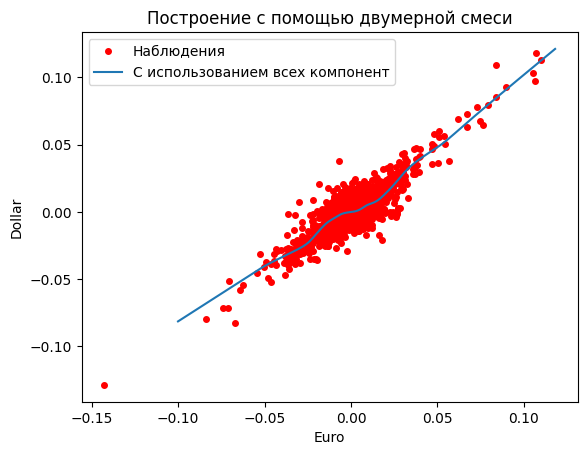

In [ ]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

### **Расчёт с помощью прямой формулы**

In [15]:
def p_a(a, gmm, cov_type):
    if cov_type == 'full':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0, 0] ** 0.5) * gmm.weights_
    if cov_type == 'diag':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0] ** 0.5) * gmm.weights_
    if cov_type == 'spherical':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_ ** 0.5) * gmm.weights_
    if cov_type == 'tied':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[0, 0] ** 0.5) * gmm.weights_
    

# def p_a_i(a, gmm, i):
#     return norm.pdf(a, gmm.means_[i, 0], gmm.covariances_[i, 0, 0] ** 0.5)

def E_y_a (a, gmm, cov_type):
    if cov_type == 'full':
        return gmm.means_[:, 1] + gmm.covariances_[:, 0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[:, 0, 0]
    if cov_type == 'diag':
        return gmm.means_[:, 1]
    if cov_type == 'spherical':
        return gmm.means_[:, 1]
    if cov_type == 'tied':
        return gmm.means_[:, 1] + gmm.covariances_[0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[0, 0]

In [16]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(data_XY)
gmm.covariances_

array([[[2.57324931e-05, 7.18643916e-06],
        [7.18643916e-06, 1.67718693e-05]],

       [[3.92046151e-04, 3.43646740e-04],
        [3.43646740e-04, 3.72388614e-04]]])

In [17]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
p_a_s = p_a(np.array(a_s).reshape(-1, 1), gmm, 'full')
res = (E_y_a(np.array(a_s).reshape(-1, 1), gmm, 'full') * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

In [ ]:
# p_a_s = p_a(np_data_euro, best_2_dim_gmm)
# res = (E_y_a(np_data_euro, best_2_dim_gmm) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

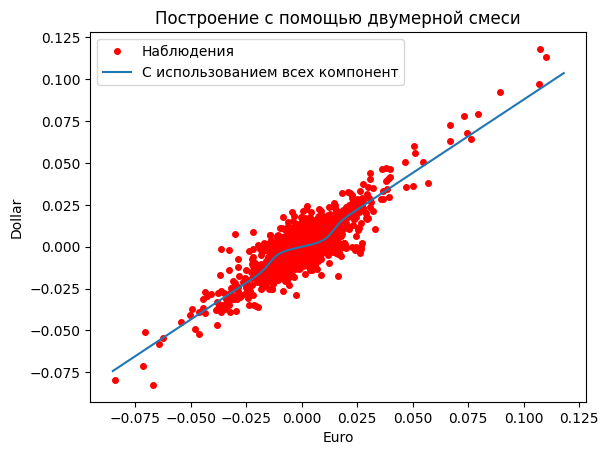

In [18]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

## **Подбираем лучшую модель по BIC**

In [19]:
def p_a(a, gmm, cov_type):
    if cov_type == 'full':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0, 0] ** 0.5) * gmm.weights_
    if cov_type == 'diag':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0] ** 0.5) * gmm.weights_
    if cov_type == 'spherical':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_ ** 0.5) * gmm.weights_
    if cov_type == 'tied':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[0, 0] ** 0.5) * gmm.weights_
    

# def p_a_i(a, gmm, i):
#     return norm.pdf(a, gmm.means_[i, 0], gmm.covariances_[i, 0, 0] ** 0.5)

def E_y_a (a, gmm, cov_type):
    if cov_type == 'full':
        return gmm.means_[:, 1] + gmm.covariances_[:, 0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[:, 0, 0]
    if cov_type == 'diag':
        return gmm.means_[:, 1]
    if cov_type == 'spherical':
        return gmm.means_[:, 1]
    if cov_type == 'tied':
        return gmm.means_[:, 1] + gmm.covariances_[0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[0, 0]

In [21]:
var_Y = np_data_dollar.var(ddof= 1)
max_R_2 = 0
min_cov = 1

min_bic = np.inf
best_bic_R_2 = 0
best_bic_cov = 1

bics = []
R_s = []
covs = []

cv_types = ['spherical', 'tied', 'diag', 'full']
# cv_types = ['full']
n_components_range = range(1, 20)
for n_components in n_components_range:
    print(f"Сейчас обучается модель с {n_components} компонентами")
    cur_R_s = []
    cur_covs = []
    cur_bics = []
    for cv_type in cv_types:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(data_XY)

        p_a_s = p_a(np_data_euro, gmm, cv_type)
        res = (E_y_a(np_data_euro, gmm, cv_type) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

        E_Y_X = res.reshape(-1, 1)
        residiuals = np_data_dollar - E_Y_X
        covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

        var_E_X_Y = E_Y_X.var(ddof= 1)
        var_resid = sum((residiuals ** 2) / (n_samples - 1))

        density = gaussian_kde(residiuals.T[0])
        LogLikelihood = np.log(density(residiuals.T[0])).sum()

        R_2 = var_E_X_Y / var_Y
        cov_part = 2 * covar / var_Y
        bic = -2 * LogLikelihood + (5 * n_components + n_components - 1) * np.log(n_samples)

        cur_bics.append(bic)
        cur_R_s.append(R_2)
        cur_covs.append(cov_part)

        if cov_part <= 0.05 and R_2 > max_R_2:
            max_R_2 = R_2
            min_cov = cov_part
            best_gmm = gmm

        if bic < min_bic:
            min_bic = bic
            best_gmm_bic = gmm
            best_bic_R_2 = R_2
            best_bic_cov = cov_part
    
    bics.append(cur_bics)
    R_s.append(cur_R_s)
    covs.append(cur_covs)

Сейчас обучается модель с 1 компонентами
Сейчас обучается модель с 2 компонентами
Сейчас обучается модель с 3 компонентами
Сейчас обучается модель с 4 компонентами
Сейчас обучается модель с 5 компонентами
Сейчас обучается модель с 6 компонентами
Сейчас обучается модель с 7 компонентами
Сейчас обучается модель с 8 компонентами
Сейчас обучается модель с 9 компонентами
Сейчас обучается модель с 10 компонентами
Сейчас обучается модель с 11 компонентами
Сейчас обучается модель с 12 компонентами
Сейчас обучается модель с 13 компонентами
Сейчас обучается модель с 14 компонентами
Сейчас обучается модель с 15 компонентами
Сейчас обучается модель с 16 компонентами
Сейчас обучается модель с 17 компонентами
Сейчас обучается модель с 18 компонентами
Сейчас обучается модель с 19 компонентами


In [22]:
R_S = np.array(R_s)
COVS = np.array(covs)
BICS = np.array(bics)

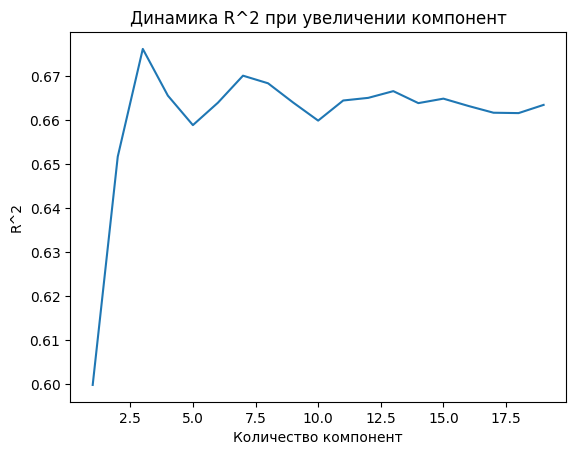

In [23]:
plt.title('Динамика R^2 при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('R^2')
plt.plot(n_components_range, R_S[:, 3])
plt.show()

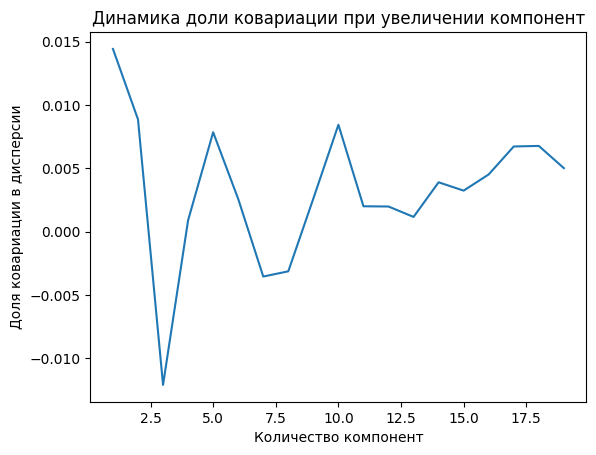

In [24]:
plt.title('Динамика доли ковариации при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Доля ковариации в дисперсии')
plt.plot(n_components_range, COVS[:, 3])
plt.show()

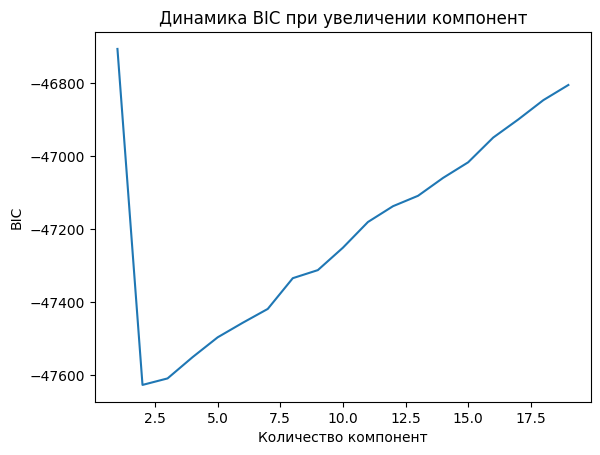

In [25]:
plt.title('Динамика BIC при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('BIC')
plt.plot(n_components_range, BICS[:, 3])
plt.show()

In [26]:
print(f"Лучший R^2: {max_R_2}")
print(f"Соответствующая доля ковариации: {min_cov}")
best_gmm

Лучший R^2: 0.6926129396705116
Соответствующая доля ковариации: -0.03629104490929572


GaussianMixture(covariance_type='tied', n_components=9)

In [28]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {best_bic_R_2}")
print(f"Соответствующая доля ковариации: {best_bic_cov}")
best_gmm_bic

Лучший BIC: -47625.81929730172
Соответствующий R^2: 0.651694701664344
Соответствующая доля ковариации: 0.008860322129568941


GaussianMixture(n_components=2)

In [30]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
p_a_s = p_a(np.array(a_s).reshape(-1, 1), best_gmm_bic, 'full')
res = (E_y_a(np.array(a_s).reshape(-1, 1), best_gmm_bic, 'full') * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

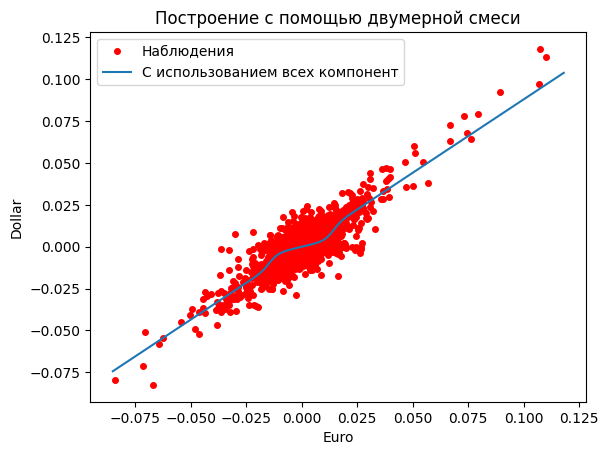

In [31]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

# **Расчёт метода в байесовском случае**

## **Выбираем лучшую модель**

In [26]:
best_2_dim_gmm = mixture.BayesianGaussianMixture(n_components=4, max_iter=10000)
best_2_dim_gmm.fit(data_XY)
best_2_dim_gmm.weights_

array([0.64288614, 0.06401036, 0.25249884, 0.04060466])

In [13]:
def p_a(a, gmm, cov_type):
    if cov_type == 'full':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0, 0] ** 0.5) * gmm.weights_
    if cov_type == 'diag':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0] ** 0.5) * gmm.weights_
    if cov_type == 'spherical':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_ ** 0.5) * gmm.weights_
    if cov_type == 'tied':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[0, 0] ** 0.5) * gmm.weights_
    

# def p_a_i(a, gmm, i):
#     return norm.pdf(a, gmm.means_[i, 0], gmm.covariances_[i, 0, 0] ** 0.5)

def E_y_a (a, gmm, cov_type):
    if cov_type == 'full':
        return gmm.means_[:, 1] + gmm.covariances_[:, 0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[:, 0, 0]
    if cov_type == 'diag':
        return gmm.means_[:, 1]
    if cov_type == 'spherical':
        return gmm.means_[:, 1]
    if cov_type == 'tied':
        return gmm.means_[:, 1] + gmm.covariances_[0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[0, 0]

In [18]:
var_Y = np_data_dollar.var(ddof= 1)
max_R_2 = 0
min_cov = 1

min_bic = np.inf
best_bic_R_2 = 0
best_bic_cov = 1

bics = []
R_s = []
covs = []

n_components_range = range(1, 13)
cv_types = ['spherical', 'tied', 'diag', 'full']
weight_concentration_prior_types = ['dirichlet_process', 'dirichlet_distribution']
weight_concentration_priors = [10 ** i for i in range(-5, 6)]
mean_precision_priors = [10 ** i for i in range(-5, 6)]
# n_components = 20

for n_components in n_components_range:
    print(f'Сейчас считаются модели для вида: {n_components} компонент')
    R_s_1 = []
    covs_1 = []
    bics_1 = []
    for cv_type in cv_types:
        R_s_2 = []
        covs_2 = []
        bics_2 = []
        print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type}')
        for weight_concentration_prior_type in weight_concentration_prior_types:
            print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type} и wcpt = {weight_concentration_prior_type}')
            R_s_3 = []
            covs_3 = []
            bics_3 = []
            for weight_concentration_prior in weight_concentration_priors:
                print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type}, wcpt = {weight_concentration_prior_type} и wcp = {weight_concentration_prior}')
                R_s_4 = []
                covs_4 = []
                bics_4 = []
                for mean_precision_prior in mean_precision_priors:
                    print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type}, wcpt = {weight_concentration_prior_type}, wcp = {weight_concentration_prior} и wmp = {mean_precision_prior}')
                    gmm = mixture.BayesianGaussianMixture(
                        n_components= n_components, 
                        max_iter= 10000, 
                        weight_concentration_prior_type= weight_concentration_prior_type,
                        weight_concentration_prior = weight_concentration_prior,
                        covariance_type= cv_type,
                        mean_precision_prior= mean_precision_prior
                        )
                    gmm.fit(data_XY)

                    p_a_s = p_a(np_data_euro, gmm, cv_type)
                    res = (E_y_a(np_data_euro, gmm, cv_type) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

                    E_Y_X = res.reshape(-1, 1)
                    residiuals = np_data_dollar - E_Y_X
                    covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

                    var_E_X_Y = E_Y_X.var(ddof= 1)
                    var_resid = sum((residiuals ** 2) / (n_samples - 1))

                    density = gaussian_kde(residiuals.T[0])
                    LogLikelihood = np.log(density(residiuals.T[0])).sum()

                    R_2 = var_E_X_Y / var_Y
                    cov_part = 2 * covar / var_Y
                    if cv_type == 'full':
                        bic = -2 * LogLikelihood + (5 * n_components + n_components - 1) * np.log(n_samples)
                    elif cv_type == 'tied':
                        bic = -2 * LogLikelihood + (2 * n_components + 3 + n_components - 1) * np.log(n_samples)
                    elif cv_type == 'diag':
                        bic = -2 * LogLikelihood + (4 * n_components + n_components - 1) * np.log(n_samples)
                    else:
                        bic = -2 * LogLikelihood + (3 * n_components + n_components - 1) * np.log(n_samples)

                    bics_4.append(bic)
                    R_s_4.append(R_2)
                    covs_4.append(cov_part)

                    if abs(cov_part) <= 0.05 and R_2 > max_R_2:
                        max_R_2 = R_2
                        min_cov = cov_part
                        best_gmm = gmm

                    if bic < min_bic:
                        min_bic = bic
                        best_gmm_bic = gmm
                        best_bic_R_2 = R_2
                        best_bic_cov = cov_part

                bics_3.append(bics_4)
                R_s_3.append(R_s_4)
                covs_3.append(covs_4)

            bics_2.append(bics_3)
            R_s_2.append(R_s_3)
            covs_2.append(covs_3)

        bics_1.append(bics_2)
        R_s_1.append(R_s_2)
        covs_1.append(covs_2)

    bics.append(bics_1)
    R_s.append(R_s_1)
    covs.append(covs_1)


Сейчас считаются модели для вида: 1 компонент
Сейчас считаются модели для вида: 1 компонент, spherical
Сейчас считаются модели для вида: 1 компонент, spherical и wcpt = dirichlet_process
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process и wcp = 1e-05
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 1e-05
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.0001
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.001
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.01
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.1
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 1
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt

In [19]:
R_S = np.array(R_s)
COVS = np.array(covs)
BICS = np.array(bics)
n_of_priors = list(range(len(weight_concentration_priors)))

In [20]:
R_S.tofile("R_S_2.txt", sep=" ")
COVS.tofile("COVS_2.txt", sep=" ")
BICS.tofile("BICS_2.txt", sep=" ")

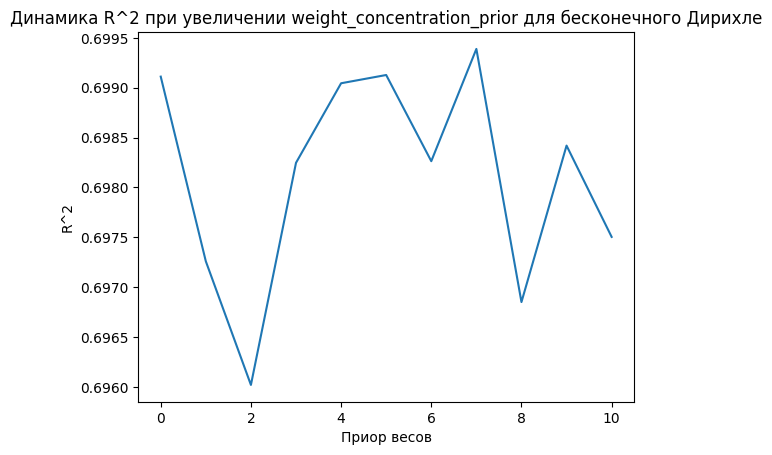

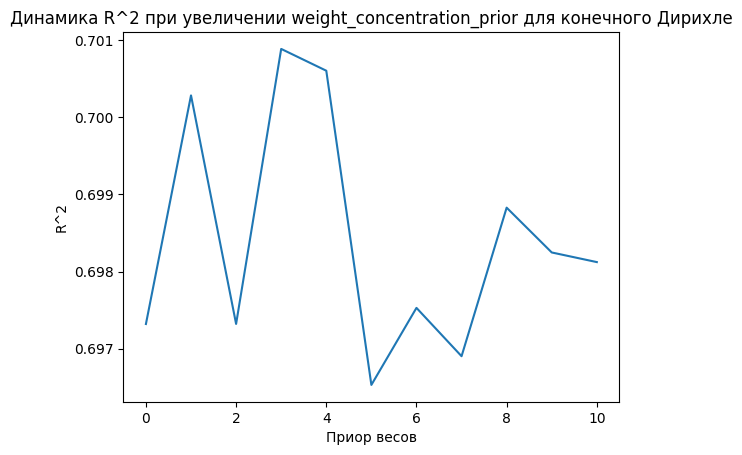

In [ ]:
plt.title('Динамика R^2 при увеличении weight_concentration_prior для бесконечного Дирихле')
plt.xlabel('Приор весов')
plt.ylabel('R^2')
plt.plot(n_of_priors, R_S[:, 3, 0, :])
plt.show()

plt.title('Динамика R^2 при увеличении weight_concentration_prior для конечного Дирихле')
plt.xlabel('Приор весов')
plt.ylabel('R^2')
plt.plot(n_of_priors, R_S[3, 1, :])
plt.show()

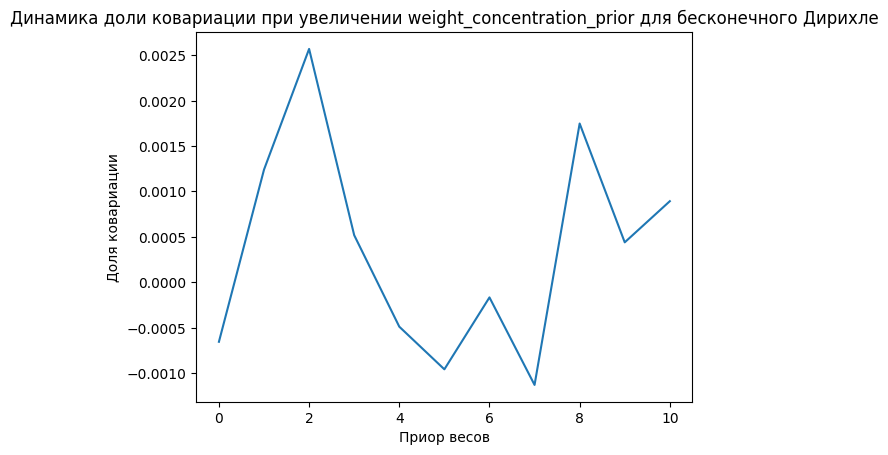

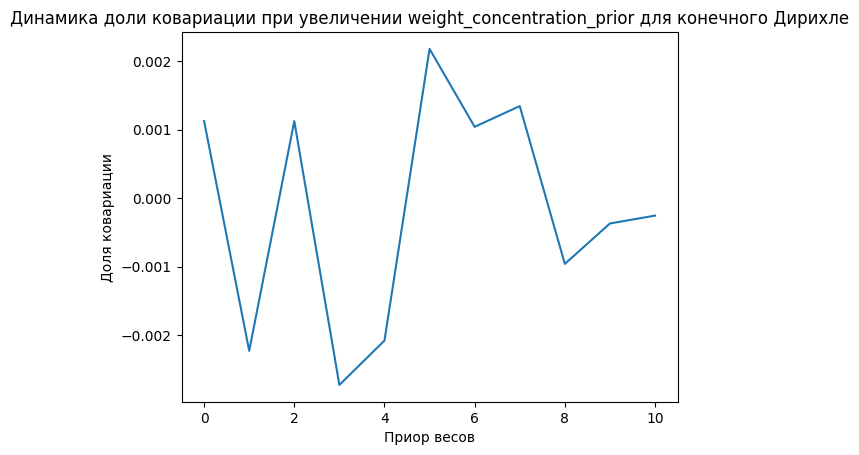

In [62]:
plt.title('Динамика доли ковариации при увеличении weight_concentration_prior для бесконечного Дирихле')
plt.xlabel('Приор весов')
plt.ylabel('Доля ковариации')
plt.plot(n_of_priors, COVS[3, 0, :])
plt.show()

plt.title('Динамика доли ковариации при увеличении weight_concentration_prior для конечного Дирихле')
plt.xlabel('Приор весов')
plt.ylabel('Доля ковариации')
plt.plot(n_of_priors, COVS[3, 1, :])
plt.show()

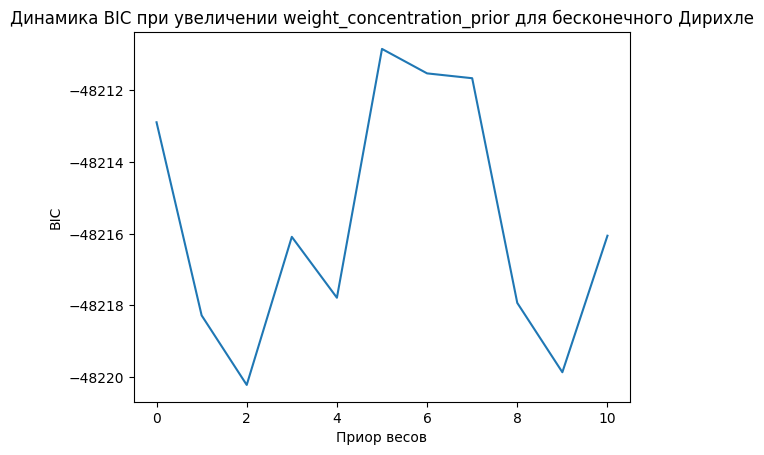

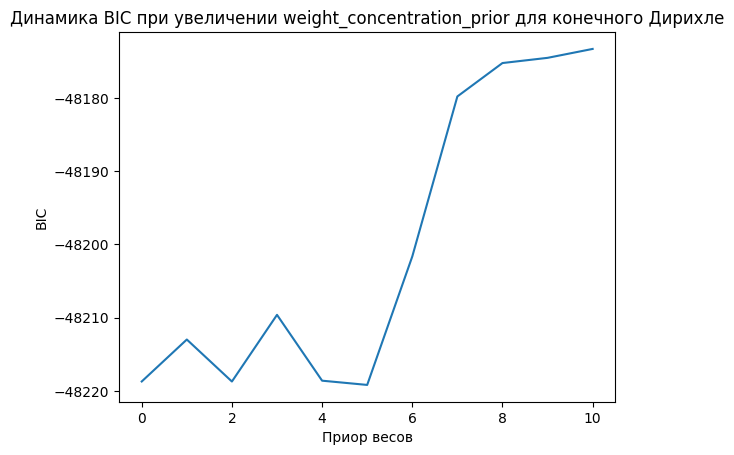

In [63]:
plt.title('Динамика BIC при увеличении weight_concentration_prior для бесконечного Дирихле')
plt.xlabel('Приор весов')
plt.ylabel('BIC')
plt.plot(n_of_priors, BICS[3, 0, :])
plt.show()

plt.title('Динамика BIC при увеличении weight_concentration_prior для конечного Дирихле')
plt.xlabel('Приор весов')
plt.ylabel('BIC')
plt.plot(n_of_priors, BICS[3, 1, :])
plt.show()

In [21]:
print(f"Лучший R^2: {max_R_2}")
print(f"Соответствующая доля ковариации: {min_cov}")
best_gmm

Лучший R^2: 0.7410285670412181
Соответствующая доля ковариации: -0.04987940925400885


BayesianGaussianMixture(covariance_type='tied', max_iter=10000,
                        mean_precision_prior=1e-05, n_components=12,
                        weight_concentration_prior=0.0001,
                        weight_concentration_prior_type='dirichlet_distribution')

In [22]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {best_bic_R_2}")
print(f"Соответствующая доля ковариации: {best_bic_cov}")
best_gmm_bic

Лучший BIC: -49092.64191581583
Соответствующий R^2: 0.7078001322689088
Соответствующая доля ковариации: -0.01215400942086859


BayesianGaussianMixture(max_iter=10000, mean_precision_prior=1e-05,
                        n_components=3, weight_concentration_prior=100,
                        weight_concentration_prior_type='dirichlet_distribution')

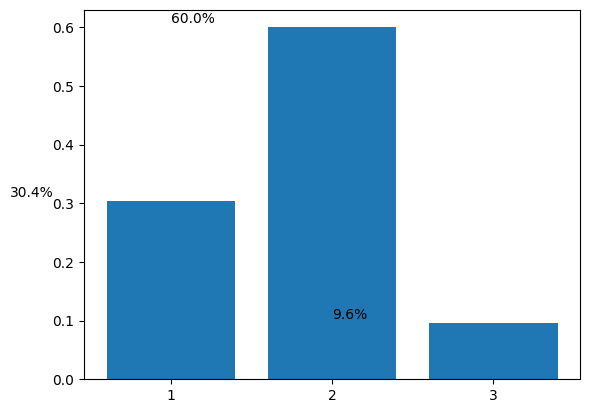

In [ ]:
plt.bar(range(1, 4), best_gmm_bic.weights_, tick_label = [str(i) for i in range(1, 4)], align = 'center')
for k, w in enumerate(best_gmm_bic.weights_):
    if w > 0.01:
        plt.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
plt.show()

In [68]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
p_a_s = p_a(np.array(a_s).reshape(-1, 1), best_gmm_bic, 'full')
res = (E_y_a(np.array(a_s).reshape(-1, 1), best_gmm_bic, 'full') * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

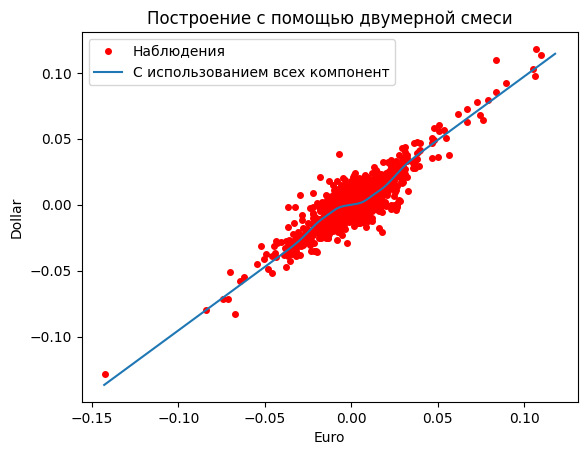

In [69]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

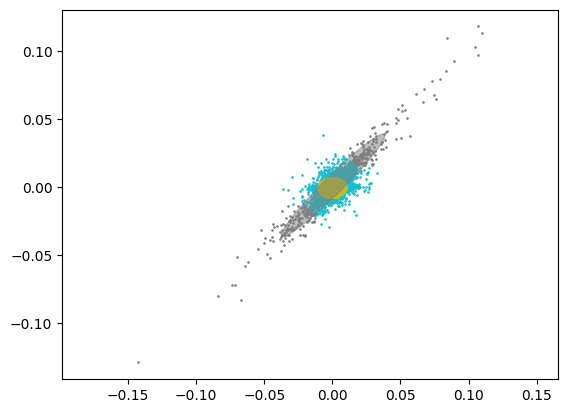

In [ ]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 20)[::-1]
Y_ = best_gmm_bic.predict(data_XY)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        best_gmm_bic.means_,
        best_gmm_bic.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(data_XY[Y_ == i, 0], data_XY[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.axis("equal")
plt.show()

## **Анализ лучшей модели**

### **Обучение модели**

In [20]:
best_gmm = mixture.BayesianGaussianMixture(max_iter=10000, mean_precision_prior=0.00001,
                        n_components=3, weight_concentration_prior=100,
                        weight_concentration_prior_type='dirichlet_distribution')
best_gmm.fit(data_XY)
gmm = best_gmm
n_components = best_gmm.n_components

In [21]:
def p_a(a, gmm, cov_type):
    if cov_type == 'full':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0, 0] ** 0.5) * gmm.weights_
    if cov_type == 'diag':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0] ** 0.5) * gmm.weights_
    if cov_type == 'spherical':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_ ** 0.5) * gmm.weights_
    if cov_type == 'tied':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[0, 0] ** 0.5) * gmm.weights_
    

# def p_a_i(a, gmm, i):
#     return norm.pdf(a, gmm.means_[i, 0], gmm.covariances_[i, 0, 0] ** 0.5)

def E_y_a (a, gmm, cov_type):
    if cov_type == 'full':
        return gmm.means_[:, 1] + gmm.covariances_[:, 0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[:, 0, 0]
    if cov_type == 'diag':
        return gmm.means_[:, 1]
    if cov_type == 'spherical':
        return gmm.means_[:, 1]
    if cov_type == 'tied':
        return gmm.means_[:, 1] + gmm.covariances_[0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[0, 0]

In [22]:
var_Y = np_data_dollar.var(ddof= 1)

p_a_s = p_a(np_data_euro, gmm, 'full')
res = (E_y_a(np_data_euro, gmm, 'full') * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

E_Y_X = res.reshape(-1, 1)
residiuals = np_data_dollar - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

var_E_X_Y = E_Y_X.var(ddof= 1)
var_resid = sum((residiuals ** 2) / (n_samples - 1))

density = gaussian_kde(residiuals.T[0])
LogLikelihood = np.log(density(residiuals.T[0])).sum()

R_2 = var_E_X_Y / var_Y
cov_part = 2 * covar / var_Y
bic = -2 * LogLikelihood + (5 * 3 + 3 - 1) * np.log(n_samples)

In [23]:
R_2, cov_part

(0.7078001324078408, -0.012154009583959216)

### **Изменение энтропии**

#### **Энтропия до**

**Веса**

In [18]:
weight_concentration_priors = np.array([best_gmm.weight_concentration_prior_] * n_components)
weights_entropy_before = dirichlet.entropy(weight_concentration_priors)
weights_entropy_before

-4.519401651700264

**Средние**

In [19]:
means_entropy_before = norm.entropy(best_gmm.mean_prior_, (1 / best_gmm.mean_precision_prior_) ** 0.5).sum() * n_components
means_entropy_before

43.05240759413873

**Ковариационная матрица**

In [20]:
covariance_entropy_before = wishart.entropy(best_gmm.degrees_of_freedom_prior_, best_gmm.covariance_prior_ / best_gmm.degrees_of_freedom_prior_) * n_components
covariance_entropy_before

-82.73130127569897

**Сумма**

In [21]:
total_entropy_before = weights_entropy_before + means_entropy_before + covariance_entropy_before
total_entropy_before

-44.1982953332605

#### **Энтропия после**

**Веса**

In [22]:
weights_entropy_after = dirichlet.entropy(best_gmm.weight_concentration_)
weights_entropy_after

-7.976647510920884

**Средние**

In [23]:
means_entropy_after = norm.entropy(best_gmm.means_, (1 / best_gmm.mean_precision_.reshape(-1, 1)) ** 0.5).sum()
means_entropy_after

-13.563903215497238

**Ковариационная матрица**

In [24]:
covariance_entropy_after = 0
for i in range(len(best_gmm.covariances_)):
    # print(wishart.entropy(best_gmm.degrees_of_freedom_[i], best_gmm.covariances_[i] / best_gmm.degrees_of_freedom_[i]))
    covariance_entropy_after += wishart.entropy(best_gmm.degrees_of_freedom_[i], best_gmm.covariances_[i] / best_gmm.degrees_of_freedom_[i])
covariance_entropy_after

-107.09559807357459

**Сумма**

In [25]:
total_entropy_after = weights_entropy_after + means_entropy_after + covariance_entropy_after
total_entropy_after

-128.63614879999272

**ОБЩЕЕ ИЗМЕННИЕ**

In [26]:
total_entropy_after - total_entropy_before

-84.43785346673222

### **Расстояние Кульбака — Лейблера**

**Веса**

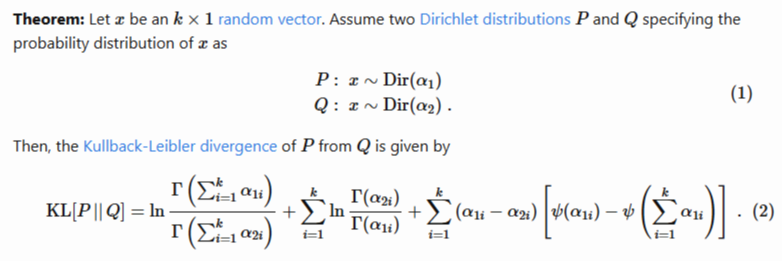

In [27]:
def kl_divergence_dirichlet(alpha, beta):
    """
    Вычисляет KL-дивергенцию между двумя распределениями Дирихле.

    Параметры:
    alpha : массив параметров первого распределения Дирихле.
    beta : массив параметров второго распределения Дирихле.

    Возвращает:
    KL-дивергенцию D_{KL}(P || Q).
    """
    # Суммы параметров
    sum_alpha = np.sum(alpha)
    sum_beta = np.sum(beta)
    
    # Первый член: log(Gamma(sum_alpha) / Gamma(sum_beta))
    term1 = gammaln(sum_alpha) - gammaln(sum_beta)
    
    # Второй член: sum(log(Gamma(beta_i) / Gamma(alpha_i)))
    term2 = np.sum(gammaln(beta) - gammaln(alpha))
    
    # Третий член: sum((alpha_i - beta_i) * (psi(alpha_i) - psi(sum_alpha)))
    term3 = np.sum((alpha - beta) * (psi(alpha) - psi(sum_alpha)))
    
    # Суммируем все члены
    kl_div = term1 + term2 + term3
    return kl_div

# Пример использования
alpha = best_gmm.weight_concentration_  # Параметры первого распределения Дирихле
beta = weight_concentration_priors   # Параметры второго распределения Дирихле

kl_value_weights = kl_divergence_dirichlet(alpha, beta)
print(f"KL-дивергенция D(P || Q) = {kl_value_weights}")

KL-дивергенция D(P || Q) = 76.80808411598082


**Средние**

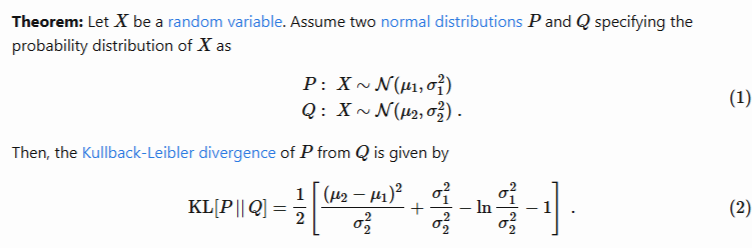

In [1]:
def kl_divergence_normal_1d(mu1, sigma1, mu2, sigma2):
    """
    Вычисляет KL-дивергенцию между двумя одномерными нормальными распределениями.

    Параметры:
    mu1 : среднее первого распределения.
    sigma1 : стандартное отклонение (sqrt(дисперсии)) первого распределения.
    mu2 : среднее второго распределения.
    sigma2 : стандартное отклонение (sqrt(дисперсии)) второго распределения.

    Возвращает:
    KL-дивергенцию D_{KL}(P || Q).
    """
    # Вычисляем KL-дивергенцию по формуле

    term1 = ((mu2 - mu1) ** 2) / (sigma2 ** 2)
    term2 = (sigma1 ** 2) / (sigma2 ** 2)
    term3 = - (np.log(term2) + 1)
    kl_div = 0.5 * ( term1 + term2 + term3)
    return kl_div

In [24]:
kl_mean_total = 0

for i in range(n_components):
    for j in range(len(best_gmm.means_[i])):
        kl_mean_total += kl_divergence_normal_1d(best_gmm.means_[i][j], 1 / best_gmm.mean_precision_[i] ** 0.5, best_gmm.mean_prior_[j], 1 / best_gmm.mean_precision_prior_ ** 0.5)

kl_mean_total

53.61631075070529

**Ковариационная матрица**

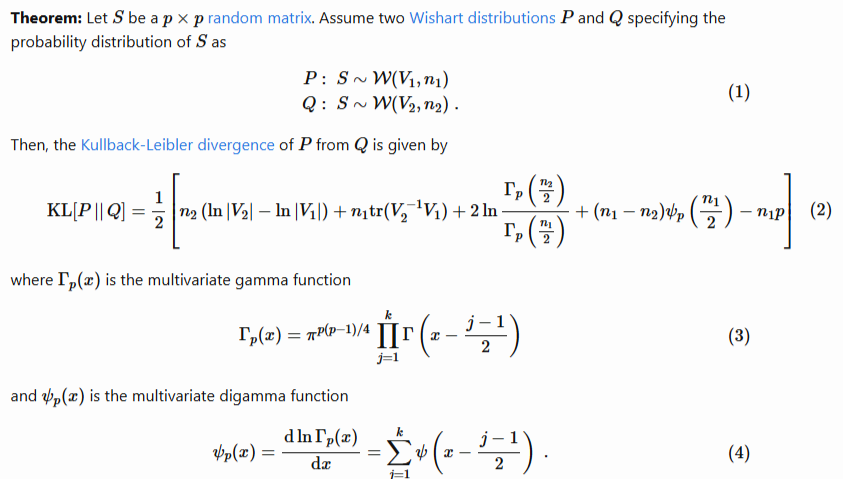

In [25]:
import numpy as np
from scipy.special import gamma, digamma, multigammaln

def multivariate_gamma(x, p):
    return np.pi**(p*(p-1)/4) * np.prod([gamma(x - (j-1)/2) for j in range(1, p+1)])

def multivariate_digamma(x, p):
    return np.sum([digamma(x - (j-1)/2) for j in range(1, p+1)])

def kl_divergence(V1, V2, n1, n2, p):
    term1 = n2 * (np.log(np.linalg.det(V2)) - np.log(np.linalg.det(V1)))
    term2 = n1 * np.trace(np.linalg.inv(V2) @ V1)
    term3 = 2 * (multigammaln(n2/2, p) - multigammaln(n1/2, p))
    term4 = (n1 - n2) * multivariate_digamma(n1/2, p)
    term5 = -n1 * p
    
    kl = 0.5 * (term1 + term2 + term3 + term4 + term5)
    return kl


V2 = best_gmm.covariance_prior_ / best_gmm.degrees_of_freedom_prior_
n2 = best_gmm.degrees_of_freedom_prior_
p = V2.shape[0]

kl_cov_total = 0

for i in range(len(best_gmm.covariances_)):
    n1 = best_gmm.degrees_of_freedom_[i]
    V1 = best_gmm.covariances_[i] / best_gmm.degrees_of_freedom_[i]
    kl_cov_total += kl_divergence(V1, V2, n1, n2, p)

print(f"KL-дивергенция D(P || Q) = {kl_cov_total}")

KL-дивергенция D(P || Q) = 35.19845121585047
